We will reproduce the [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html) here.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
%matplotlib inline
import hddm
import kabuki
print(hddm.__version__)

0.8.0


## Loading data

In [3]:
# find the directory of "cavanagh_theta_nn.csv"
print(hddm.__file__)

/opt/conda/lib/python3.7/site-packages/hddm/__init__.py


In [4]:
!head /opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


In [5]:
data = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


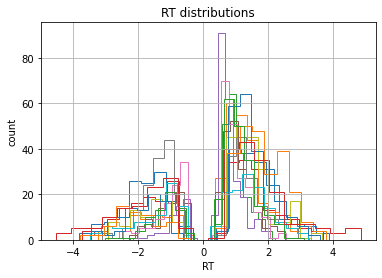

In [6]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

## Fitting a hierarchical model

In [12]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
m = hddm.HDDM(data)
# find a good starting point which helps with the convergence.
m.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m.sample(2000, burn=20)

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 102.6 sec----------------46%                  ] 939 of 2000 complete in 49.1 sec

In [13]:
stats = m.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.97793,0.0938443,1.81312,1.91695,1.97532,2.0337,2.1702,0.00277819
a_std,0.337861,0.0812846,0.221105,0.281754,0.322981,0.377027,0.537845,0.00305825
a_subj.0,2.19627,0.064814,2.06828,2.15396,2.19658,2.23975,2.32759,0.00214256
a_subj.1,2.11945,0.0656518,1.99465,2.07364,2.11855,2.1651,2.24837,0.00234945


Plotting a
Plotting a_std
Plotting v
Plotting t


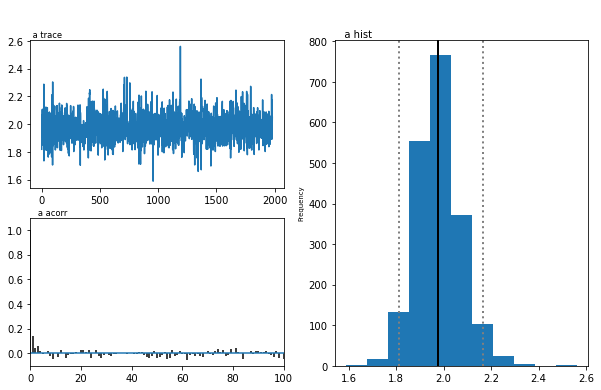

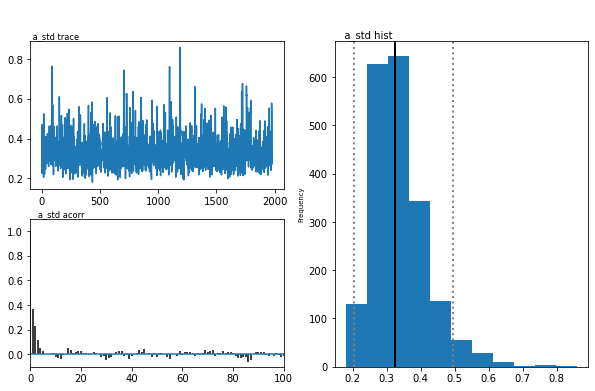

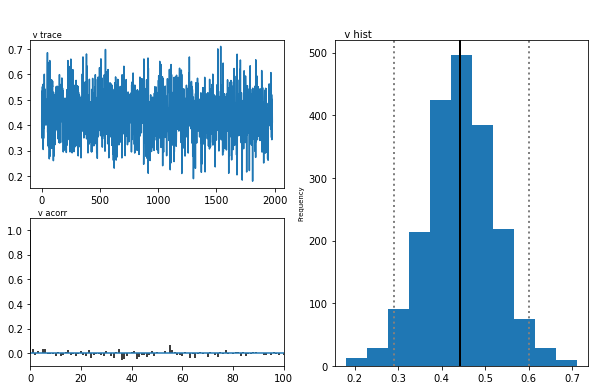

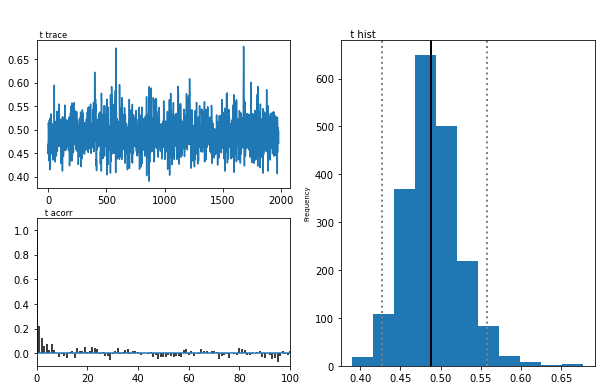

In [14]:
m.plot_posteriors(['a', 't', 'v', 'a_std'])

In [15]:
models = []
for i in range(5):
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(5000, burn=20)
    models.append(m)

hddm.analyze.gelman_rubin(models)

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5000 of 5000 complete in 258.5 sec--------         22%                  ] 1105 of 5000 complete in 57.1 sec[---               9%                  ] 471 of 5000 complete in 25.0 sec[--------------   39%                  ] 1960 of 5000 complete in 101.8 sec[-----------------62%---               ] 3119 of 5000 complete in 160.8 sec

{'a': 1.0000456266272575,
 'a_std': 0.9999634931436437,
 'a_subj.0': 0.9999882622209986,
 'a_subj.1': 0.9999741287211041,
 'a_subj.2': 1.0002980628236247,
 'a_subj.3': 1.0004293656252676,
 'a_subj.4': 1.0000592555201173,
 'a_subj.5': 1.000180991524688,
 'a_subj.6': 1.0002482373649317,
 'a_subj.7': 1.0001802243483164,
 'a_subj.8': 1.0000821706241954,
 'a_subj.9': 0.9999652377863228,
 'a_subj.10': 1.0001778547519427,
 'a_subj.11': 1.0001418559644384,
 'a_subj.12': 0.999962129767885,
 'a_subj.13': 1.0001323813776615,
 'v': 1.000315838001674,
 'v_std': 1.0000540851439208,
 'v_subj.0': 0.9999113108798006,
 'v_subj.1': 0.9999915538744788,
 'v_subj.2': 1.0000207536203825,
 'v_subj.3': 0.9999262192887716,
 'v_subj.4': 0.999994847975146,
 'v_subj.5': 0.9999785915768906,
 'v_subj.6': 1.0000009587537797,
 'v_subj.7': 1.0000505904235535,
 'v_subj.8': 1.0000358527228561,
 'v_subj.9': 1.0002129298324853,
 'v_subj.10': 1.0001778241840118,
 'v_subj.11': 1.0002357920878062,
 'v_subj.12': 1.000112628795

you can also replace the for-loop with parallel processing:

In [7]:
# define a function to run model in parallel
def run_model(id):
    print('running model%i'%id);
    
    import hddm
    
    exp_name = 'cavanagh'
    model_tag = 'm1'
    
    #### USE absolute pathes in docker.
    # define the database name, which uses pickle format
    dbname = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id 
    # define the name for the model
    mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    
    fname  = '/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv'
    data = hddm.load_csv(fname)
    
    m2 = hddm.HDDM(data)
    m2.find_starting_values()
    m2.sample(5000, burn=20,dbname=dbname, db='pickle') # it's neccessary to save the model data
    m2.save(mname)
    
    return m2

In [8]:
# define a function to check the progress bar of the sampling
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=15):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

In [11]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_model, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

models_2 = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
285.518s elapsed

running model0
 [-----------------99%----------------- ] 4963 of 5000 complete in 283.1 sec
running model1
 [-----------------100%-----------------] 5000 of 5000 complete in 282.5 sec
running model2
 [-----------------99%----------------- ] 4953 of 5000 complete in 283.1 sec
running model3
 [-----------------99%----------------- ] 4987 of 5000 complete in 282.8 sec



Running 4 chains used: 300.522058 seconds.


In [12]:
hddm.analyze.gelman_rubin(models_2)

{'a': 1.0003999138820805,
 'a_std': 1.0010011140363562,
 'a_subj.0': 1.000030813043581,
 'a_subj.1': 1.0002232838852338,
 'a_subj.2': 1.00004038212095,
 'a_subj.3': 1.0000323270681726,
 'a_subj.4': 1.0004990109379797,
 'a_subj.5': 1.0001780182323394,
 'a_subj.6': 1.000027070685103,
 'a_subj.7': 1.0005937485707201,
 'a_subj.8': 1.0002609206708202,
 'a_subj.9': 1.0000567149372543,
 'a_subj.10': 1.0003240418505366,
 'a_subj.11': 0.9999652446622244,
 'a_subj.12': 1.000042940456519,
 'a_subj.13': 1.0001073443569048,
 'v': 1.000127621681884,
 'v_std': 1.0002381409445908,
 'v_subj.0': 1.0000048205103949,
 'v_subj.1': 1.0002671752960923,
 'v_subj.2': 0.9999735435658739,
 'v_subj.3': 0.9999176969149721,
 'v_subj.4': 1.0000698927797265,
 'v_subj.5': 0.9999758964673107,
 'v_subj.6': 1.0000473183288527,
 'v_subj.7': 1.0000337405402666,
 'v_subj.8': 0.9999065436343423,
 'v_subj.9': 1.000051806631063,
 'v_subj.10': 1.0002397318821095,
 'v_subj.11': 1.0000379500161631,
 'v_subj.12': 1.000013913412264

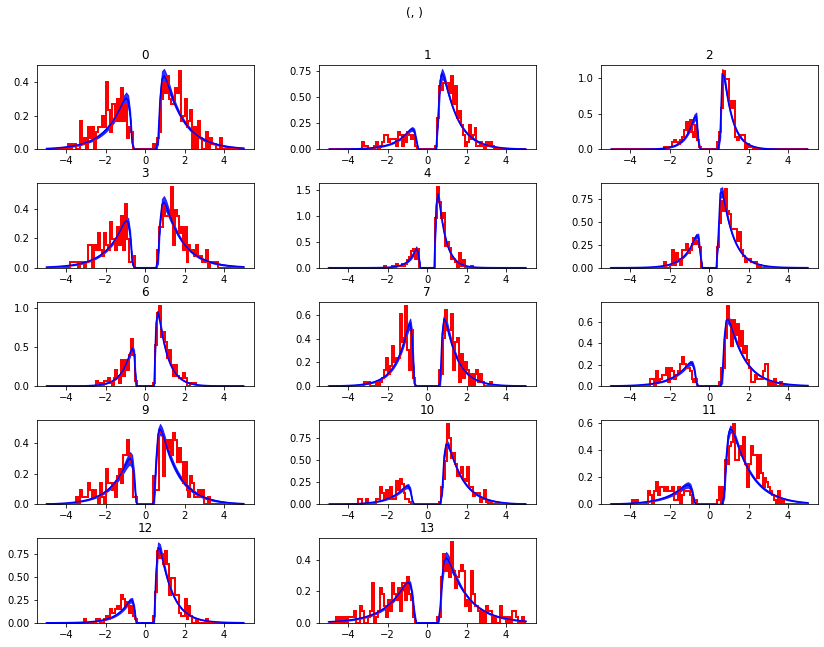

In [14]:
models_2[0].plot_posterior_predictive(figsize=(14, 10))

In [17]:
m_comb = kabuki.utils.concat_models(models_2) # combine four chains together

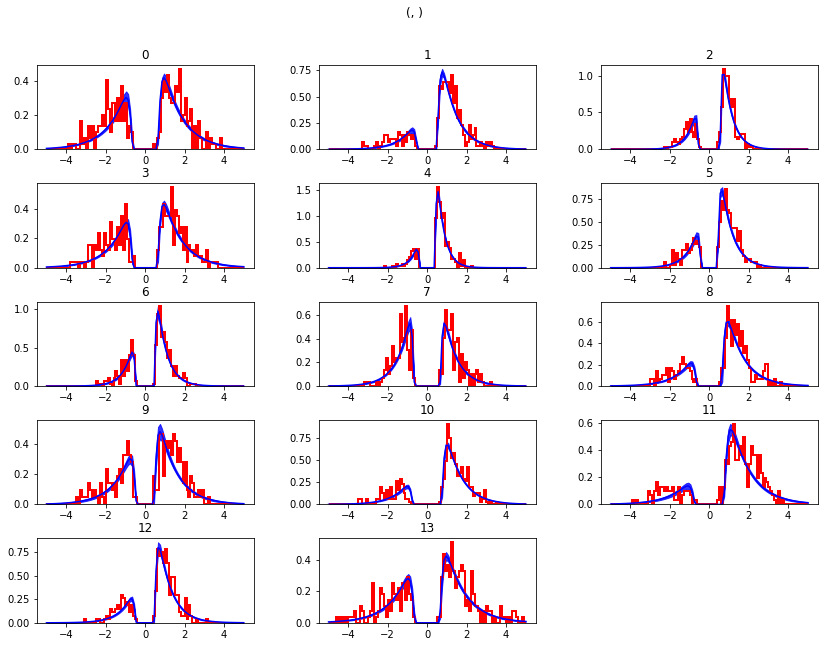

In [18]:
m_comb.plot_posterior_predictive(figsize=(14, 10))

In [19]:
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 10000 of 10000 complete in 1192.9 sec

Text(0.5, 1.0, 'Posterior of drift-rate group means')

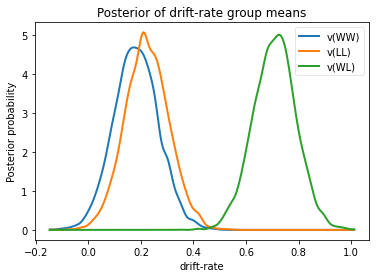

In [20]:
v_WW, v_LL, v_WL = m_stim.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
# plt.savefig('hddm_demo_fig_06.pdf')

In [21]:
print("P(WW > LL) = ", (v_WW.trace() > v_LL.trace()).mean())
print("P(LL > WL) = ", (v_LL.trace() > v_WL.trace()).mean())

P(WW > LL) =  0.36744444444444446
P(LL > WL) =  0.00011111111111111112


In [22]:
print("Lumped model DIC: %f" % m.dic)
print("Stimulus model DIC: %f" % m_stim.dic)

NameError: name 'm' is not defined

## Within-subject effects

In [23]:
from patsy import dmatrix
dmatrix("C(stim, Treatment('WL'))", data.head(10))

DesignMatrix with shape (10, 3)
  Intercept  C(stim, Treatment('WL'))[T.LL]  C(stim, Treatment('WL'))[T.WW]
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
  Terms:
    'Intercept' (column 0)
    "C(stim, Treatment('WL'))" (columns 1:3)

In [24]:
m_within_subj = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))")

Adding these covariates:
['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"]


In [25]:
m_within_subj.sample(5000, burn=200)

 [-----------------100%-----------------] 5000 of 5000 complete in 1222.0 sec

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

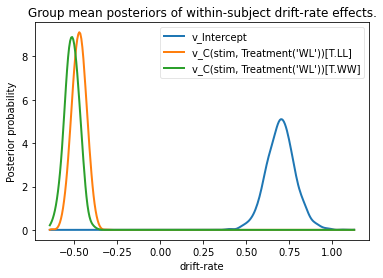

In [28]:
v_WL, v_LL, v_WW = m_within_subj.nodes_db.loc[["v_Intercept",
                                              "v_C(stim, Treatment('WL'))[T.LL]",
                                              "v_C(stim, Treatment('WL'))[T.WW]"], 'node']
hddm.analyze.plot_posterior_nodes([v_WL, v_LL, v_WW])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

## Fitting regression models

In [29]:
m_reg = hddm.HDDMRegressor(data[data.dbs == 0],
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'stim'})
m_reg.sample(5000, burn=200)

Adding these covariates:
['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]", "a_theta:C(conf, Treatment('LC'))[LC]"]
 [-----------------100%-----------------] 5001 of 5000 complete in 1993.5 sec

P(a_theta < 0) =  0.053125


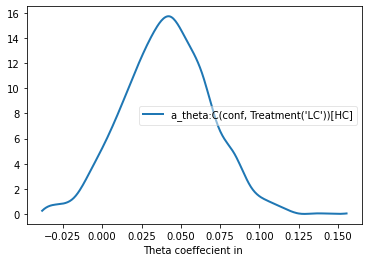

In [30]:
theta = m_reg.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=20)
plt.xlabel('Theta coeffecient in ')
print("P(a_theta < 0) = ", (theta.trace() < 0).mean())

In [31]:
m_reg_off = hddm.HDDMRegressor(data[data.dbs == 1],
                               "a ~ theta:C(conf, Treatment('LC'))",
                               depends_on={'v': 'stim'})
m_reg_off.sample(5000, burn=200)

Adding these covariates:
['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]", "a_theta:C(conf, Treatment('LC'))[LC]"]
 [-----------------100%-----------------] 5001 of 5000 complete in 2200.1 sec

P(a_theta > 0) =  0.052708333333333336


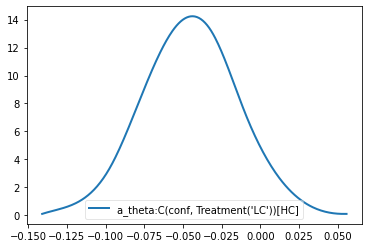

In [32]:
theta = m_reg_off.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=10)
print("P(a_theta > 0) = ", (theta.trace() > 0).mean())

## Dealing witih outliers

In [33]:
outlier_data, params = hddm.generate.gen_rand_data(params={'a': 2, 't': .4, 'v': .5},
                                                   size=200, n_fast_outliers=10)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
m_no_outlier = hddm.HDDM(outlier_data)
m_no_outlier.sample(2000, burn=50)

 [-----------------100%-----------------] 2000 of 2000 complete in 7.7 sec

Text(0, 0.5, 'Probability density')

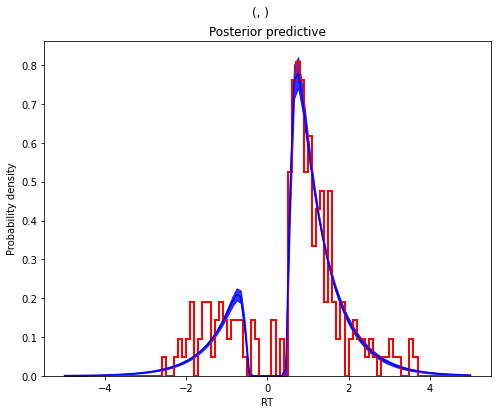

In [35]:
m_no_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_10.pdf')

In [36]:
m_outlier = hddm.HDDM(outlier_data, p_outlier=.05)
m_outlier.sample(2000, burn=20)

 [-----------------100%-----------------] 2000 of 2000 complete in 7.5 sec

Text(0, 0.5, 'Probability density')

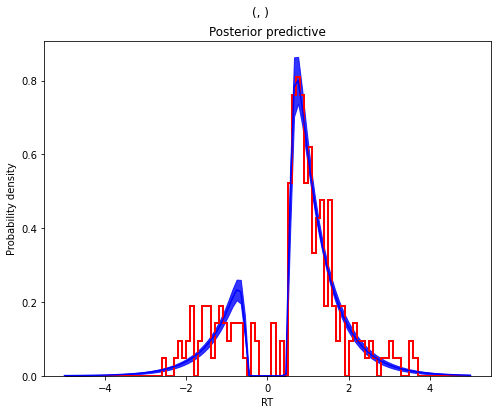

In [37]:
m_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_11.pdf')